# Deep Learning for Deciphering Traffic Signs
## MLP Notebook
_________________________________________________________________________________________________________________________________________________________________________________

##### Contributors:
 Victor Floriano, Yifan Fan, Jose Salerno

## Problem Statement & Motivation
As the world advances towards autonomous vehicles, our team has observed the remarkable efforts of large car manufacturers, who are working with data scientists to develop fully autonomous cars. Our team is excited to contribute to the development of this technology by creating a neural network model that will be able to classify different traffic signs. Our ultimate goal is to assist car makers in overcoming the challenges they may face in implementing neural network models that effectively read traffic signs and further their efforts toward a fully autonomous car or assisted driving. We believe autonomous driving to be an important problem to solve due to the great economic benefits it can generate for car manufacturers and the improvement of general driving safety.

## Data Preparation
 We've selected the German Traffic Sign Recognition Benchmark (GTSRB) as our primary dataset. It's renowned for its complexity, featuring over 50,000 images across more than 40 classes of traffic signs. The GTSRB is publicly accessible through two resources. To efficiently manage the extensive and complex GTSRB dataset, our strategy integrates preprocessing for uniformity, data augmentation for robustness, and batch processing for computational efficiency. We'll employ distributed computing to parallelize operations, enhancing processing speed, and use stratified sampling for quick experimentation without compromising representativeness.



---





# MLP Notebook


In this notebook, a multi-layer perceptron (MLP) model was developed to classify images from GTSRB. The model's architecture and hyperparameters were optimized using a randomized search implemented with Weights & Biases (W&B). Key hyperparameters such as batch size, number of hidden layers, and learning rate were varied across a defined range to determine the best combination for minimizing validation loss. Data preprocessing included resizing, normalization, and data augmentation (like rotation and flipping) to enhance the model's robustness against varied visual inputs. Additionally, the MLP was adapted to handle image input by flattening the image tensors into vectors suitable for processing through the network's fully connected layers.

The training process was carefully managed using tools like early stopping to prevent overfitting and ensure computational efficiency. The model was trained on a GPU to expedite the computation, and various metrics like training loss and accuracy were monitored and logged using W&B. The MLP's effectiveness was quantified by calculating accuracy and loss on both the training and validation datasets. This approach provided a systematic way to explore a wide configuration space and optimize the model's performance on the traffic sign classification task.

Unfortunately, due to constraints on our time and computational resources, we were able to search through only 10 model configurations (9 executed to completion), and for a maximum of 15 epochs.


________________________________________________________________________________________________________________________________________________

Results: These are the results for each configuration of our MLP models. Our BEST model was Sweep 7 with Validation Accuracy: 81.89%.

| Name     | Batch Normalization | Batch Size | Data Augmentation | Dropout Rate | Hidden Layer Size | Input Layer Size | Learning Rate | Number of Hidden Layers | Weight Decay Value | Validation Accuracy |
|----------|---------------------|------------|-------------------|--------------|-------------------|------------------|---------------|-------------------------|--------------------|---------------------|
| Sweep-10 | False               | 2000       | False             | 0.0          | 100               | 200              | 0.001         | 5                       | 0.0000             | 43.71%              |
| Sweep-8  | False               | 2000       | True              | 0.0          | 200               | 200              | 0.001         | 5                       | 0.0000             | 28.58%              |
| Sweep-7  | True                | 2000       | False             | 0.3          | 200               | 100              | 0.010         | 2                       | 0.0001             | 81.89%              |
| Sweep-6  | True                | 200        | True              | 0.0          | 200               | 100              | 0.010         | 3                       | 0.0010             | 59.81%              |
| Sweep-5  | False               | 2000       | False             | 0.0          | 200               | 100              | 0.001         | 2                       | 0.0000             | 70.33%              |
| Sweep-4  | True                | 200        | True              | 0.0          | 100               | 100              | 0.001         | 3                       | 0.0010             | 74.15%              |
| Sweep-3  | False               | 200        | True              | 0.0          | 50                | 100              | 0.010         | 3                       | 0.0010             | 60.71%              |
| Sweep-2  | False               | 2000       | True              | 0.0          | 200               | 200              | 0.001         | 5                       | 0.0000             | 2.33%               |
| Sweep-1  | False               | 200        | False             | 0.0          | 100               | 200              | 0.010         | 5                       | 0.0010             | 55.17%              |


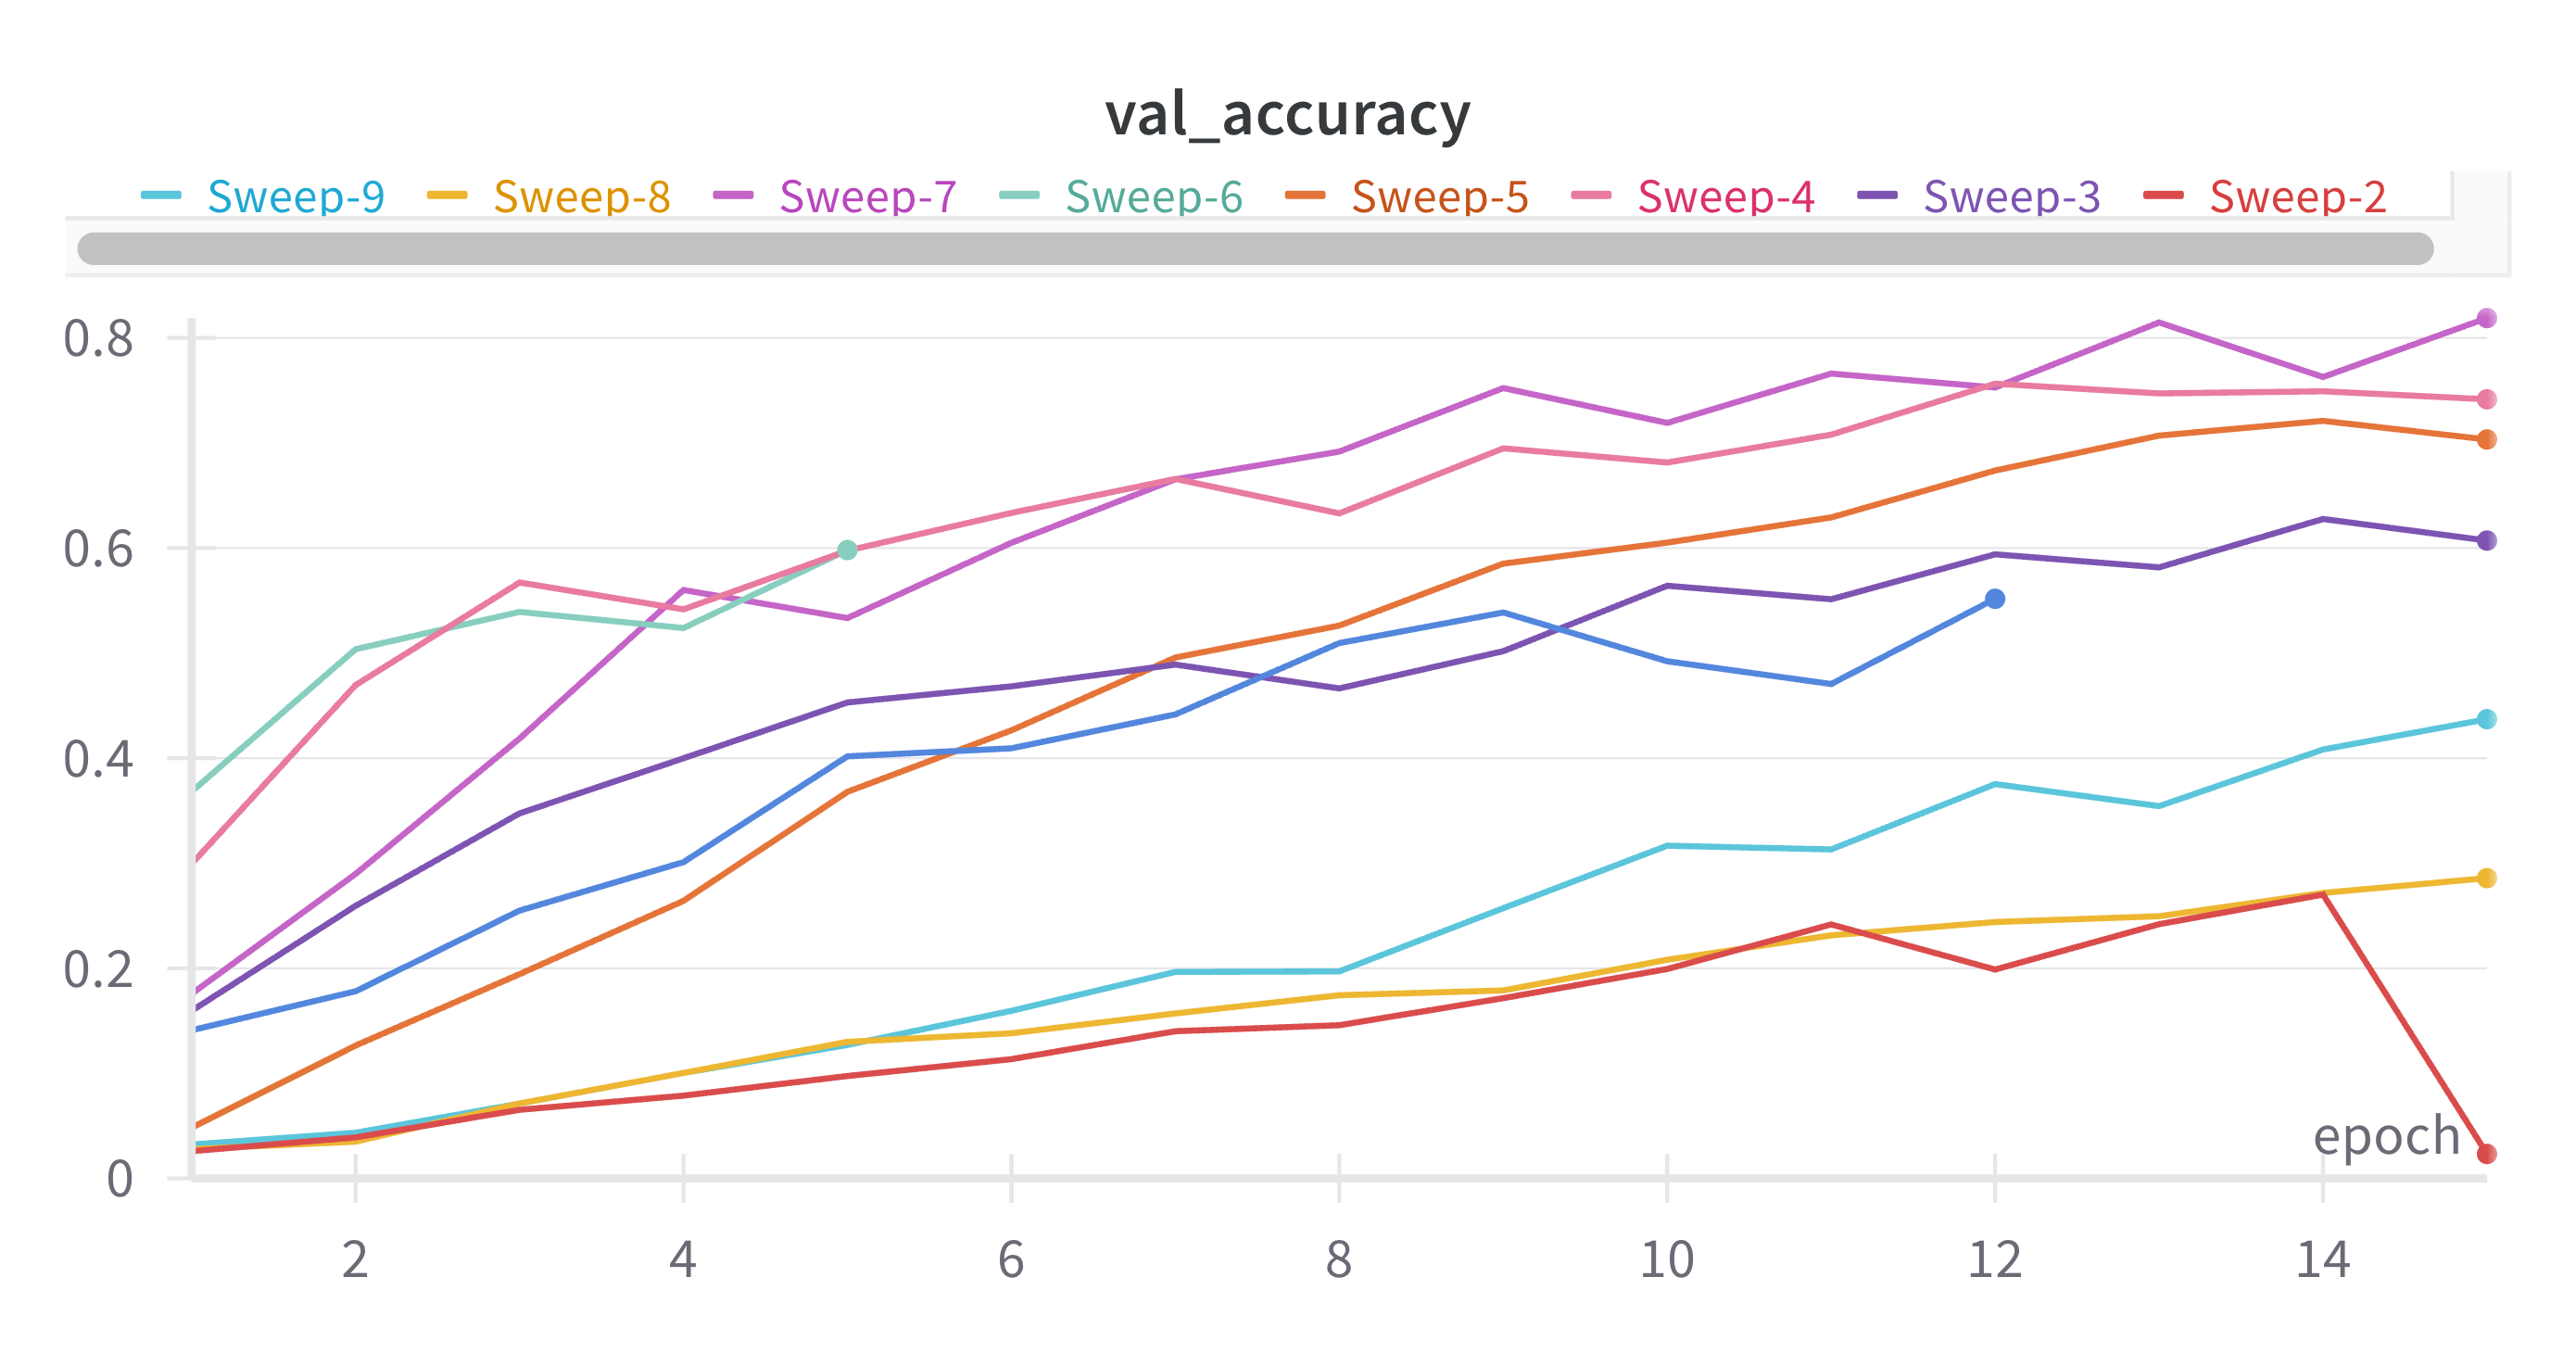

In [ ]:
!unzip /content/Train.zip

In [ ]:
!unzip /content/Test_organized.zip

In [ ]:
!pip install torchinfo

In [ ]:
!pip install torchmetrics

In [ ]:
!pip install wandb

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchinfo import summary

Rertieve data from Google Drive - needs to be altered for SCC

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Hyperparameters

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: victorgf (victorgfloriano). Use `wandb login --relogin` to force relogin


True

In [ ]:
#Create Sweep - wandb

n_classes = 43 #This parameter is set outiside of the sweep since it should not be changed in any instance

sweep_config ={
    'method' : 'random',
    'metric' : {'goal':'minimize', 'name':'validation_loss'},

    'parameters' : {
        'batch_size' : {'values': [200,2000]},
        'resized_resolution' : {'values': [16]},
        'data_augmentation' : {'values': [False, True]},
        'n_classes' : {'values': [n_classes]},
        'input_layer_size' : {'values' : [100,200]},
        'hidden_layer_size' : {'values' : [50,100,200]},
        'n_hidden_layers' : {'values' : [2,3,4,5]},
        'weight_decay_value' : {'values': [0,0.0001,0.001]},
        'learning_rate' : {'values': [0.001, 0.01]},
        'epochs' : {'values':[15]},
        'early_stop_patience' : {'values':[3]},
        'batch_normalization' : {'values': [True,False]},
        'dropout_rate' : {'values':[0,0.3]}

    }
}


In [ ]:
#Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="ba865-group-project-mlp-test20-sweep")

Create sweep with ID: iehyafp7
Sweep URL: https://wandb.ai/victorgfloriano/ba865-group-project-mlp-test20-sweep/sweeps/iehyafp7


In [ ]:
def create_secondary_params(resized_resolution):
  """
  This function will create secondary parameters used by the model.
  It had to be transformed into a function because it requires values assgined
  by the current W&B sweep
  """
  image_dimensions = (3, resized_resolution, resized_resolution)
  input_size = image_dimensions[0] * image_dimensions[1] * image_dimensions[2]
  device='cuda' if torch.cuda.is_available() else 'cpu'

  return image_dimensions, input_size, device

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2 #v2 is faster than normal transforms
from torch.utils.data import Subset
import numpy as np

def create_data_loaders(resized_resolution, batch_size, data_augmentation):
  """
  This function will create the dataloaders used by the model.
  It had to be transformed into a function because it requires values assgined
  by the current W&B sweep
  """

  #Convert data to Tensor, Resize, Normalize values, and applies data augmentation
  #such parameter is selected - Train
  if data_augmentation == True:

    train_transforms = transforms.Compose([
        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), #Converts to Tensor and Scales [0,1] - Old ToTensor()
        v2.Resize((resized_resolution, resized_resolution)),   #Size 32
        v2.Normalize((0.5,),(0.5,)), #Changes range to [-1,1]/ Applies to all channels
        v2.RandomRotation(10),
        v2.RandomHorizontalFlip(0.2),
        v2.RandomPerspective(0.5, 0.2)      #Applies a perspective shift to the image (20% of chance)
    ])

  else:

    train_transforms = transforms.Compose([
        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), #Converts to Tensor and Scales [0,1] - Old ToTensor()
        v2.Resize((resized_resolution, resized_resolution)),   #Size 32
        v2.Normalize((0.5,), (0.5,)), #Changes range to [-1,1]/ Applies to all channels
          ])

  #Convert data to Tensor, Resize, Normalize values - Test
  test_transforms = transforms.Compose([
        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), #Converts to Tensor and Scales [0,1] - Old ToTensor()
        v2.Resize((resized_resolution, resized_resolution)),   #Size 32
        v2.Normalize((0.5,),(0.5,)), #Changes range to [-1,1]/ Applies to all channels
          ])


  #Use image folder to get Images with the right class label for Train and Test
  train_dataset = ImageFolder(
      #'/content/drive/MyDrive/BU_MSBA/BA865 - Neural Networks/BA865 - Group Project/GTSRBkaggle/Train',
      '/content/Train',
      transform = train_transforms
  )

  # indices = np.random.choice(len(train_dataset), 200, replace=False) #REMOVE AFTER TEST
  # train_dataset = Subset(train_dataset, indices)

  test_dataset = ImageFolder(
      #'/content/drive/MyDrive/BU_MSBA/BA865 - Neural Networks/BA865 - Group Project/GTSRBkaggle/Test_organized',
      '/content/Test_organized',
      transform = test_transforms
  )

  #Separate Train and Validation
  train_dataset, validation_dataset = random_split(train_dataset, [0.8, 0.2])

  #Create DataLoaders
  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

Create MLP Model, loss metric and optimizer

In [ ]:
#MLP Model

def create_mlp_model(input_size, input_layer_size, n_hidden_layers,
                  hidden_layer_size, learning_rate, weight_decay_value,
                     batch_normaliation, dropout_rate):
  """
  This function will create the model.
  It had to be transformed into a function because it requires values assgined
  by the current W&B sweep
  """



  class MLP(nn.Module):
      def __init__(self, input_size, input_layer_size, n_hidden_layers, hidden_layer_size, n_classes, batch_normalization, dropout_rate):
          super(MLP, self).__init__()

          #Initialize the list of layers
          layers = []

          #Start with the first layer from input to first hidden layer
          layers.append(nn.Linear(input_size, input_layer_size))
          if batch_normalization:                                     #Adds batch normalization as needed
            layers.append(nn.BatchNorm1d(input_layer_size))
          layers.append(nn.ReLU())
          if dropout_rate != 0:                                        #Adds dropouts as needed
            layers.append(nn.Dropout(dropout_rate))

          #Create the first hidden layer
          layers.append(nn.Linear(input_layer_size, hidden_layer_size))
          if batch_normalization:
            layers.append(nn.BatchNorm1d(hidden_layer_size))
          layers.append(nn.ReLU())
          if dropout_rate != 0:
            layers.append(nn.Dropout(dropout_rate))

          #Adding hidden layers, each with size 'hidden_size'
          for _ in range(1, n_hidden_layers):
            layers.append(nn.Linear(hidden_layer_size, hidden_layer_size))
            if batch_normalization:
                layers.append(nn.BatchNorm1d(hidden_layer_size))
            layers.append(nn.ReLU())
            if dropout_rate != 0:
                layers.append(nn.Dropout(dropout_rate))

          #Output layer
          layers.append(nn.Linear(hidden_layer_size, n_classes))

          # Create a sequential container with all the layers
          self.mlp = nn.Sequential(*layers)

      def forward(self, x):
          x = x.view(x.size(0), -1)
          return self.mlp(x)


  #Create model
  mlp_model = MLP(input_size, input_layer_size, n_hidden_layers,
                  hidden_layer_size, n_classes, batch_normaliation,dropout_rate)


  #Store model in CUDA if availabel
  if torch.cuda.is_available():
    mlp_model.cuda()

  print(summary(mlp_model))


  #Define Loss
  criterion = nn.CrossEntropyLoss() #add weight here to adjust for class imbalance(IMPORTANT)


  #AdamW is structured to better apply weight decay
  optimizer = optim.AdamW(mlp_model.parameters(), lr=learning_rate,
                            weight_decay=weight_decay_value)


  return mlp_model, criterion, optimizer

Define Function to get Accuracy

In [ ]:
import torchmetrics

def get_accuracy(dataloader, model, device='cpu'):

    was_training = model.training

    #Create an accuracy metric instance
    acc = torchmetrics.Accuracy(num_classes=n_classes, average='macro', task='multiclass').to(device)

    #Set model to evaluation mode
    model.eval()

    #Set model to gpu if available
    model.to(device)

    with torch.no_grad():
        for images, labels in dataloader:
            #Move images and labels to the correct device - gpu when available
            images = images.to(device)
            labels = labels.to(device)

            #Get model outputs
            outputs = model(images)

            #Get model predictions - torchmetrics.Accuracy needs predictions, not logits or p-dist to calculate accuracy
            predictions = torch.argmax(outputs, axis=1)

            #Update the accuracy metric for each batch
            acc.update(predictions, labels)

    # Compute the final accuracy for all batches
    final_accuracy = acc.compute()

    if was_training:
      model.train() #Sets model back to training if it was. training

    return final_accuracy

#use as -> accuracy = get_accuracy(your_dataloader, mlp_model, device='cuda' if torch.cuda.is_available() else 'cpu')

Define Function to get Loss mertic

In [ ]:
def get_loss(loader, model, criterion, device):
    """
    Compute the average loss of the model on a dataset.

    Parameters:
    - loader (DataLoader): The DataLoader for the dataset to evaluate.
    - model (torch.nn.Module): The neural network model.
    - criterion (callable): The loss function.
    - device (str): The device to perform computation on ('cuda' or 'cpu').

    Returns:
    - float: The average loss over the dataset.
    """
    was_training = model.training

    model.eval()  # Set the model to evaluation mode.
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)  # Multiply loss by batch size
            total_samples += images.size(0)

    average_loss = total_loss / total_samples  # Normalize by total number of samples

    if was_training:

      model.train() #Sets the model back to training if it was training

    return average_loss

Define Early Stopper

In [ ]:
class EarlyStopper:
    def __init__(self, model, patience=3):
        self.model = model
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(self.model.state_dict(), "./best_model.pt")
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            wandb.log({'early_stop_counter':self.counter}) #Log to wandb to check for issues
            if self.counter >= self.patience:
                return True
        return False

Training Model

In [ ]:
def train(config=None):

  #Initialize a new wandb run
  with wandb.init(config=config):
    config = wandb.config #Current configuration will be defined by the sweep

    #Create important secondary params
    image_dimensions, input_size, device = create_secondary_params(config.resized_resolution)

    #Create data loaders and apply augmentations if necessary
    train_loader, val_loader, test_loader = create_data_loaders(config.resized_resolution,
                                                                config.batch_size,
                                                                config.data_augmentation)

    #Create mlp model
    mlp_model, criterion, optimizer = create_mlp_model(input_size,
                                                      config.input_layer_size,
                                                      config.n_hidden_layers,
                                                      config.hidden_layer_size,
                                                      config.learning_rate,
                                                      config.weight_decay_value,
                                                       config.batch_normalization,
                                                       config.dropout_rate)


    early_stopper = EarlyStopper(mlp_model, patience=config.early_stop_patience)

    for epoch in range(config.epochs):
      mlp_model.train()
      total_train_loss = 0 #Needed to log train loss for each epoch

      for i, (images, labels) in enumerate(train_loader):

          #Zero out gradients
          optimizer.zero_grad()

          #Move data to gpu if available
          images = images.to(device)
          labels = labels.to(device)

          #Forward Pass
          outputs = mlp_model(images)

          #Calculate loss
          loss = criterion(outputs, labels)
          total_train_loss += loss.item() * images.size(0)

          #Backward Pass
          loss.backward()
          optimizer.step()

          #Print the loss
          if i%100 == 0:
            print("Epoch", epoch+ 1, " batch.", i+1, " Training Loss:", loss.item())


      #Compute total train accuracy/validation accuracy/validation loss
      train_accuracy = get_accuracy(train_loader, mlp_model, device=device)
      validation_accuracy = get_accuracy(val_loader, mlp_model, device=device)
      validation_loss = get_loss(val_loader, mlp_model, criterion, device=device)

      print(f'Epoch [{epoch + 1}/{config.epochs}], Train Accuracy: {train_accuracy.item():.4f}, Validation Accuracy: {validation_accuracy.item():.4f}, Validation Loss: {validation_loss:.4f}')
      wandb.log({"epoch": epoch + 1,
                 "train_accuracy": train_accuracy.item(),
                 "val_accuracy": validation_accuracy.item(),
                 "train_loss": total_train_loss / len(train_loader.dataset),
                 "validation_loss": validation_loss
            })



      if early_stopper.early_stop(validation_loss):
          print("Validation loss hasn't dropped. Early stopping!")
          break

#Start the sweep with the sweep agent
wandb.agent(sweep_id, function=train, count=10)

wandb: Agent Starting Run: vnena2yy with config:
wandb: 	batch_normalization: False
wandb: 	batch_size: 200
wandb: 	data_augmentation: False
wandb: 	dropout_rate: 0
wandb: 	early_stop_patience: 3
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 100
wandb: 	input_layer_size: 200
wandb: 	learning_rate: 0.01
wandb: 	n_classes: 43
wandb: 	n_hidden_layers: 5
wandb: 	resized_resolution: 16
wandb: 	weight_decay_value: 0.001


Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       153,800
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       20,100
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       10,100
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       10,100
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       10,100
│    └─ReLU: 2-10                        --
│    └─Linear: 2-11                      10,100
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      4,343
Total params: 218,643
Trainable params: 218,643
Non-trainable params: 0
Epoch 1  batch. 1  Training Loss: 3.7521045207977295
Epoch 1  batch. 101  Training Loss: 3.1136865615844727
Epoch [1/15], Train Accuracy: 0.1385, Validation Accuracy: 0.1410, Validation Loss:

early_stop_counter,▁▁▅█
epoch,▁▂▂▃▄▄▅▅▆▇▇█
train_accuracy,▁▂▃▄▆▆▆▇█▇▇█
train_loss,█▆▅▄▃▂▂▁▁▁▁▁
val_accuracy,▁▂▃▄▅▆▆▇█▇▇█
validation_loss,██▅▄▃▃▃▁▁▂▃▂
early_stop_counter,3
epoch,12
train_accuracy,0.55701
train_loss,1.04248
val_accuracy,0.55167


wandb: Agent Starting Run: syqzyt7k with config:
wandb: 	batch_normalization: False
wandb: 	batch_size: 2000
wandb: 	data_augmentation: True
wandb: 	dropout_rate: 0
wandb: 	early_stop_patience: 3
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 200
wandb: 	input_layer_size: 200
wandb: 	learning_rate: 0.001
wandb: 	n_classes: 43
wandb: 	n_hidden_layers: 5
wandb: 	resized_resolution: 16
wandb: 	weight_decay_value: 0


Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       153,800
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       40,200
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       40,200
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       40,200
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       40,200
│    └─ReLU: 2-10                        --
│    └─Linear: 2-11                      40,200
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      8,643
Total params: 363,443
Trainable params: 363,443
Non-trainable params: 0
Epoch 1  batch. 1  Training Loss: 3.7538087368011475
Epoch [1/15], Train Accuracy: 0.0263, Validation Accuracy: 0.0259, Validation Loss: 3.4562
Epoch 2  batch. 1  Training Loss: 3.43890500068

early_stop_counter,▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▂▃▃▄▄▅▅▆▇▆▇█▁
train_loss,█▇▆▆▅▅▄▃▃▂▂▃▂▁
val_accuracy,▁▁▂▃▃▄▄▄▅▆▇▆▇█▁
validation_loss,█▇▆▆▅▅▄▄▃▂▂▃▂▁
early_stop_counter,1
epoch,15
train_accuracy,0.02326
train_loss,nan
val_accuracy,0.02326


wandb: Agent Starting Run: gsv3n1qg with config:
wandb: 	batch_normalization: True
wandb: 	batch_size: 2000
wandb: 	data_augmentation: True
wandb: 	dropout_rate: 0
wandb: 	early_stop_patience: 3
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 100
wandb: 	input_layer_size: 100
wandb: 	learning_rate: 0.001
wandb: 	n_classes: 43
wandb: 	n_hidden_layers: 4
wandb: 	resized_resolution: 16
wandb: 	weight_decay_value: 0.001


Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       76,900
│    └─BatchNorm1d: 2-2                  200
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       10,100
│    └─BatchNorm1d: 2-5                  200
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       10,100
│    └─BatchNorm1d: 2-8                  200
│    └─ReLU: 2-9                         --
│    └─Linear: 2-10                      10,100
│    └─BatchNorm1d: 2-11                 200
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      10,100
│    └─BatchNorm1d: 2-14                 200
│    └─ReLU: 2-15                        --
│    └─Linear: 2-16                      4,343
Total params: 122,643
Trainable params: 122,643
Non-trainable params: 0
Epoch 1  batch. 1  Training Loss: 3.8526451587677
Epoch [1/

Traceback (most recent call last):
  File "<ipython-input-11-cc5f678ff5a9>", line 32, in train
    for i, (images, labels) in enumerate(train_loader):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 631, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 675, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py", line 399, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py", line 399, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "/usr/local/lib/python3.10/dist-pack

epoch,▁█
train_accuracy,▁▁
val_accuracy,▁▁
epoch,2
train_accuracy,0.02326
train_loss,nan
val_accuracy,0.02326
validation_loss,nan


wandb: Agent Starting Run: k82h8j5b with config:
wandb: 	batch_normalization: False
wandb: 	batch_size: 200
wandb: 	data_augmentation: True
wandb: 	dropout_rate: 0
wandb: 	early_stop_patience: 3
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 50
wandb: 	input_layer_size: 100
wandb: 	learning_rate: 0.01
wandb: 	n_classes: 43
wandb: 	n_hidden_layers: 3
wandb: 	resized_resolution: 16
wandb: 	weight_decay_value: 0.001


Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       76,900
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       5,050
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       2,550
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       2,550
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       2,193
Total params: 89,243
Trainable params: 89,243
Non-trainable params: 0
Epoch 1  batch. 1  Training Loss: 3.7654201984405518
Epoch 1  batch. 101  Training Loss: 2.7512712478637695
Epoch [1/15], Train Accuracy: 0.1652, Validation Accuracy: 0.1595, Validation Loss: 2.3894
Epoch 2  batch. 1  Training Loss: 2.354778528213501
Epoch 2  batch. 101  Training Loss: 2.1091246604919434
Epoch [2/15], Train Accuracy: 0.2667, Validation Accuracy: 0.2594, Validati

early_stop_counter,▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▄▅▅▆▆▆▆▇▇█▇██
train_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▂▄▅▅▆▆▆▆▇▇▇▇██
validation_loss,█▆▄▄▃▃▃▃▂▂▂▁▂▁▁
early_stop_counter,1
epoch,15
train_accuracy,0.61885
train_loss,1.14877
val_accuracy,0.60707


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ufax9mn6 with config:
wandb: 	batch_normalization: True
wandb: 	batch_size: 200
wandb: 	data_augmentation: True
wandb: 	dropout_rate: 0
wandb: 	early_stop_patience: 3
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 100
wandb: 	input_layer_size: 100
wandb: 	learning_rate: 0.001
wandb: 	n_classes: 43
wandb: 	n_hidden_layers: 3
wandb: 	resized_resolution: 16
wandb: 	weight_decay_value: 0.001


Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       76,900
│    └─BatchNorm1d: 2-2                  200
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       10,100
│    └─BatchNorm1d: 2-5                  200
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       10,100
│    └─BatchNorm1d: 2-8                  200
│    └─ReLU: 2-9                         --
│    └─Linear: 2-10                      10,100
│    └─BatchNorm1d: 2-11                 200
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      4,343
Total params: 112,343
Trainable params: 112,343
Non-trainable params: 0
Epoch 1  batch. 1  Training Loss: 3.798403263092041
Epoch 1  batch. 101  Training Loss: 2.1979031562805176
Epoch [1/15], Train Accuracy: 0.3003, Validation Accuracy: 0.2994, Validation Loss: 1.887

early_stop_counter,▁▁▁█▁█
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▅▅▆▆▇▆▇▇▇████
train_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▇▆▇▇▇████
validation_loss,█▆▄▆▄▄▄▆▃▄▃▁▁▁▂
early_stop_counter,2
epoch,15
train_accuracy,0.74414
train_loss,0.60652
val_accuracy,0.74154


wandb: Agent Starting Run: cudc6upn with config:
wandb: 	batch_normalization: False
wandb: 	batch_size: 2000
wandb: 	data_augmentation: False
wandb: 	dropout_rate: 0
wandb: 	early_stop_patience: 3
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 200
wandb: 	input_layer_size: 100
wandb: 	learning_rate: 0.001
wandb: 	n_classes: 43
wandb: 	n_hidden_layers: 2
wandb: 	resized_resolution: 16
wandb: 	weight_decay_value: 0


Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       76,900
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       20,200
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       40,200
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       8,643
Total params: 145,943
Trainable params: 145,943
Non-trainable params: 0
Epoch 1  batch. 1  Training Loss: 3.7601265907287598
Epoch [1/15], Train Accuracy: 0.0465, Validation Accuracy: 0.0482, Validation Loss: 3.3321
Epoch 2  batch. 1  Training Loss: 3.3446526527404785
Epoch [2/15], Train Accuracy: 0.1265, Validation Accuracy: 0.1264, Validation Loss: 2.8594
Epoch 3  batch. 1  Training Loss: 2.8351893424987793
Epoch [3/15], Train Accuracy: 0.1928, Validation Accuracy: 0.1944, Validation Loss: 2.2408
Epoch 4  batch. 1  Training Loss: 2.

early_stop_counter,▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▂▃▄▅▆▆▇▇▇▇███
train_loss,█▇▆▄▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▂▃▃▄▅▆▆▇▇▇████
validation_loss,█▇▅▄▃▃▂▂▂▂▂▁▁▁▁
early_stop_counter,1
epoch,15
train_accuracy,0.71459
train_loss,0.71684
val_accuracy,0.7033


wandb: Agent Starting Run: in3xepr0 with config:
wandb: 	batch_normalization: True
wandb: 	batch_size: 200
wandb: 	data_augmentation: True
wandb: 	dropout_rate: 0
wandb: 	early_stop_patience: 3
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 200
wandb: 	input_layer_size: 100
wandb: 	learning_rate: 0.01
wandb: 	n_classes: 43
wandb: 	n_hidden_layers: 3
wandb: 	resized_resolution: 16
wandb: 	weight_decay_value: 0.001


Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       76,900
│    └─BatchNorm1d: 2-2                  200
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       20,200
│    └─BatchNorm1d: 2-5                  400
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       40,200
│    └─BatchNorm1d: 2-8                  400
│    └─ReLU: 2-9                         --
│    └─Linear: 2-10                      40,200
│    └─BatchNorm1d: 2-11                 400
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      8,643
Total params: 187,543
Trainable params: 187,543
Non-trainable params: 0
Epoch 1  batch. 1  Training Loss: 3.8029086589813232
Epoch 1  batch. 101  Training Loss: 1.740790605545044
Epoch [1/15], Train Accuracy: 0.3750, Validation Accuracy: 0.3681, Validation Loss: 1.793

early_stop_counter,▁▅█
epoch,▁▃▅▆█
train_accuracy,▁▅▆▆█
train_loss,█▃▂▂▁
val_accuracy,▁▅▆▆█
validation_loss,▅▁▄█▃
early_stop_counter,3
epoch,5
train_accuracy,0.61388
train_loss,0.88473
val_accuracy,0.59806


wandb: Agent Starting Run: 2cystaev with config:
wandb: 	batch_normalization: True
wandb: 	batch_size: 2000
wandb: 	data_augmentation: False
wandb: 	dropout_rate: 0.3
wandb: 	early_stop_patience: 3
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 200
wandb: 	input_layer_size: 100
wandb: 	learning_rate: 0.01
wandb: 	n_classes: 43
wandb: 	n_hidden_layers: 2
wandb: 	resized_resolution: 16
wandb: 	weight_decay_value: 0.0001


Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       76,900
│    └─BatchNorm1d: 2-2                  200
│    └─ReLU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       20,200
│    └─BatchNorm1d: 2-6                  400
│    └─ReLU: 2-7                         --
│    └─Dropout: 2-8                      --
│    └─Linear: 2-9                       40,200
│    └─BatchNorm1d: 2-10                 400
│    └─ReLU: 2-11                        --
│    └─Dropout: 2-12                     --
│    └─Linear: 2-13                      8,643
Total params: 146,943
Trainable params: 146,943
Non-trainable params: 0
Epoch 1  batch. 1  Training Loss: 3.834958076477051
Epoch [1/15], Train Accuracy: 0.1728, Validation Accuracy: 0.1756, Validation Loss: 2.4111
Epoch 2  batch. 1  Training Loss: 2.286914825439453
Epoch 

early_stop_counter,▁▁▁▁█
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▄▅▅▆▆▇▇▇▇▇█▇█
train_loss,█▆▄▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▂▄▅▅▆▆▇▇▇▇▇█▇█
validation_loss,█▆▅▃▅▃▂▂▂▃▂▂▁▂▁
early_stop_counter,2
epoch,15
train_accuracy,0.82773
train_loss,0.57777
val_accuracy,0.81887


wandb: Agent Starting Run: yq2s5rqz with config:
wandb: 	batch_normalization: False
wandb: 	batch_size: 2000
wandb: 	data_augmentation: True
wandb: 	dropout_rate: 0
wandb: 	early_stop_patience: 3
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 200
wandb: 	input_layer_size: 200
wandb: 	learning_rate: 0.001
wandb: 	n_classes: 43
wandb: 	n_hidden_layers: 5
wandb: 	resized_resolution: 16
wandb: 	weight_decay_value: 0


Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       153,800
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       40,200
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       40,200
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       40,200
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       40,200
│    └─ReLU: 2-10                        --
│    └─Linear: 2-11                      40,200
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      8,643
Total params: 363,443
Trainable params: 363,443
Non-trainable params: 0
Epoch 1  batch. 1  Training Loss: 3.7639496326446533
Epoch [1/15], Train Accuracy: 0.0277, Validation Accuracy: 0.0278, Validation Loss: 3.4507
Epoch 2  batch. 1  Training Loss: 3.44843244552

early_stop_counter,▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▂▃▄▄▅▅▅▆▇▇▇██
train_loss,█▇▆▅▄▃▃▃▂▂▂▁▁▁▁
val_accuracy,▁▁▂▃▄▄▅▅▅▆▇▇▇██
validation_loss,█▇▆▅▄▄▃▃▃▂▂▂▁▁▁
early_stop_counter,1
epoch,15
train_accuracy,0.28971
train_loss,1.95417
val_accuracy,0.2858


wandb: Agent Starting Run: c5qg82ss with config:
wandb: 	batch_normalization: False
wandb: 	batch_size: 2000
wandb: 	data_augmentation: False
wandb: 	dropout_rate: 0
wandb: 	early_stop_patience: 3
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 100
wandb: 	input_layer_size: 200
wandb: 	learning_rate: 0.001
wandb: 	n_classes: 43
wandb: 	n_hidden_layers: 5
wandb: 	resized_resolution: 16
wandb: 	weight_decay_value: 0


Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       153,800
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       20,100
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       10,100
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       10,100
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       10,100
│    └─ReLU: 2-10                        --
│    └─Linear: 2-11                      10,100
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      4,343
Total params: 218,643
Trainable params: 218,643
Non-trainable params: 0
Epoch 1  batch. 1  Training Loss: 3.7606778144836426
Epoch [1/15], Train Accuracy: 0.0325, Validation Accuracy: 0.0322, Validation Loss: 3.4641
Epoch 2  batch. 1  Training Loss: 3.47976064682

early_stop_counter,▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▁▂▂▃▃▄▄▅▆▆▇▆▇█
train_loss,█▇▇▆▅▅▄▃▃▂▂▂▂▁▁
val_accuracy,▁▁▂▂▃▃▄▄▅▆▆▇▇██
validation_loss,█▇▇▆▅▄▄▄▃▂▃▂▂▁▁
early_stop_counter,1
epoch,15
train_accuracy,0.45104
train_loss,1.30181
val_accuracy,0.43707


------

# Sources:
- Generative AI was utilized for Debugging, code improvement, class loop creation, sentence structure and grammar.
-
-
-